In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from celmech.maps import EncounterMap,solve_manifold_f_and_g, manifold_approx, func_from_series

In [2]:
emap = EncounterMap(1e-4,4,0.5,Nmax=15,mod=False)

In [3]:
Nmax=11
xunst = np.array((np.pi,0))
R_u,farr_u,garr_u=solve_manifold_f_and_g((np.pi,0),emap,11)
R_s,farr_s,garr_s=solve_manifold_f_and_g((np.pi,0),emap,11,unstable=False)
Tprime_u = lambda p: R_u@(emap(xunst + R_u.T @ p ) - xunst)
Tprime_s = lambda p: R_s@(emap.inv(xunst + R_s.T @ p ) - xunst)

(1e-16, 1)

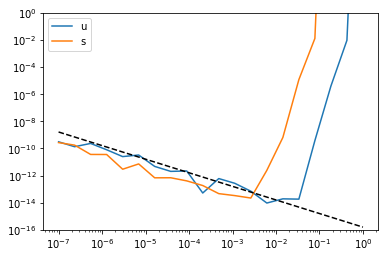

In [4]:
u0s = np.logspace(-7,0,20)
errors_u = []
errors_s = []
for u0 in u0s:
    p0,p1_approx=manifold_approx(u0,Nmax,farr_u,garr_u)
    p1 = Tprime_u(p0)
    errors_u.append(np.linalg.norm((p1-p1_approx))/np.linalg.norm(p1))
    
    
    p0,p1_approx=manifold_approx(u0,Nmax,farr_s,garr_s)
    p1 = Tprime_s(p0)
    errors_s.append(np.linalg.norm((p1-p1_approx))/np.linalg.norm(p1))
    
plt.plot(u0s,errors_u,label='u')
plt.plot(u0s,errors_s,label='s')
plt.plot(u0s,np.abs((emap(xunst)-xunst)[1]/u0s),'k--')
plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-16,1)

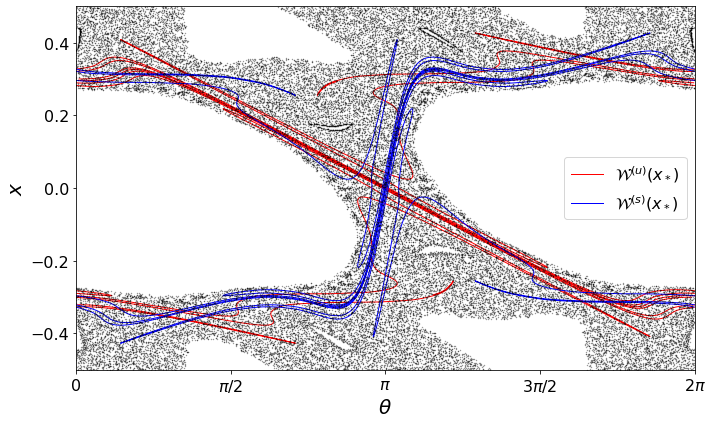

In [20]:
wrap1 = lambda x: np.mod(x+0.5,1)-0.5
wrap2pi = lambda x: np.mod(x,2*np.pi)
emap.mod_p = False
emap.mod_theta = False
Npts = 5000

u0_u=u0s[np.argmin(errors_u)]
u1_u = func_from_series(garr_u,u0_u)
uvals_u = np.linspace(u0_u,u1_u,Npts)

u0_s=u0s[np.argmin(errors_s)]
u1_s = func_from_series(garr_s,u0_s)
uvals_s = np.linspace(u0_s,u1_s,Npts)



_,pts_u = manifold_approx(uvals_u,Nmax,farr_u,garr_u)
_,pts_s = manifold_approx(uvals_s,Nmax,farr_s,garr_s)

theta_u,p_u = pts_u
theta_s,p_s = pts_s

for n in range(6):
    pts_u = np.transpose([Tprime_u(p) for p in pts_u.T])
    pts_s = np.transpose([Tprime_s(p) for p in pts_s.T])
    
    theta_u = np.concatenate((theta_u,pts_u[0]))
    p_u = np.concatenate((p_u,pts_u[1]))

    theta_s = np.concatenate((theta_s,pts_s[0]))
    p_s = np.concatenate((p_s,pts_s[1]))


theta_u,p_u = R_u.T @ [theta_u,p_u]
theta_u = wrap2pi(xunst[0] + theta_u)
p_u = wrap1(xunst[1] + p_u)

breaksX = np.abs(theta_u[1:] - theta_u[:-1])>np.pi
breaksY = np.abs(p_u[1:] - p_u[:-1])>0.5
break_indices = np.arange(len(theta_u)-1)[np.logical_or(breaksX,breaksY)]
plt.figure(figsize=(10,6))

break_indices=np.concatenate(([0],break_indices,[-1]))
for ilow,ihi in zip(break_indices[:-1],break_indices[1:]):
    if ilow==0:
        plt.plot(theta_u[ilow+1:ihi],p_u[ilow+1:ihi],'r-',lw=1,label=r"$\mathcal{W}^{(u)}(x_*)$")
    else:
        plt.plot(theta_u[ilow+1:ihi],p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(2*np.pi-theta_u[ilow+1:ihi],-1*p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(theta_u[ilow+1:ihi],1+p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(2*np.pi-theta_u[ilow+1:ihi],1-p_u[ilow+1:ihi],'r-',lw=1)


theta_s,p_s = R_s.T @ [theta_s,p_s]
theta_s = wrap2pi(xunst[0] + theta_s)
p_s = wrap1(xunst[1] + p_s)

breaksX = np.abs(theta_s[1:] - theta_s[:-1])>np.pi
breaksY = np.abs(p_s[1:] - p_s[:-1])>0.5
break_indices = np.arange(len(theta_s)-1)[np.logical_or(breaksX,breaksY)]


break_indices=np.concatenate(([0],break_indices,[-1]))
for ilow,ihi in zip(break_indices[:-1],break_indices[1:]):
    if ilow==0:
        plt.plot(theta_s[ilow+1:ihi],p_s[ilow+1:ihi],'b-',lw=1,label=r"$\mathcal{W}^{(s)}(x_*)$")
    else:
        plt.plot(theta_s[ilow+1:ihi],p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(2*np.pi-theta_s[ilow+1:ihi],-1*p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(theta_s[ilow+1:ihi],1+p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(2*np.pi-theta_s[ilow+1:ihi],1-p_s[ilow+1:ihi],'b-',lw=1)
plt.legend(fontsize=16)
x = np.array([np.pi,0.01])
xs = []
for i in range(10*Npts):
    xs.append(x)
    x = emap(x)
theta,p=np.array(xs).T
plt.plot(wrap2pi(theta),wrap1(p),'k.',ms=0.75,alpha=0.5)
plt.ylim(-0.5,0.5)
plt.tick_params(labelsize=16)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],["$0$",r"$\pi/2$",r"$\pi$",r"$3\pi/2$",r"2$\pi$"])
plt.xlabel(r"$\theta$",fontsize=20)
plt.ylabel(r"$x$",fontsize=20)
# delta = 1
plt.xlim(0,2*np.pi)
plt.ylim(-0.5,+0.5)
plt.tight_layout()
plt.savefig("./homoclinic_tangle.png")

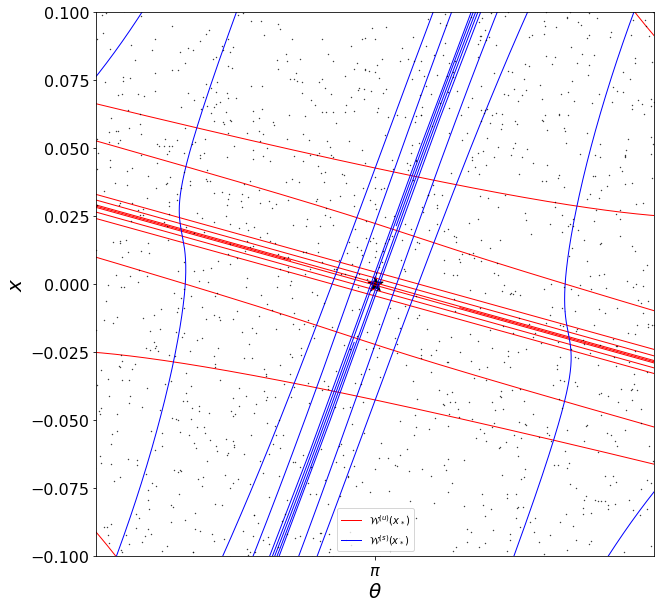

In [15]:
wrap1 = lambda x: np.mod(x+0.5,1)-0.5
wrap2pi = lambda x: np.mod(x,2*np.pi)
emap.mod_p = False
emap.mod_theta = False
Npts = 5000

u0_u=u0s[np.argmin(errors_u)]
u1_u = func_from_series(garr_u,u0_u)
uvals_u = np.linspace(u0_u,u1_u,Npts)

u0_s=u0s[np.argmin(errors_s)]
u1_s = func_from_series(garr_s,u0_s)
uvals_s = np.linspace(u0_s,u1_s,Npts)



_,pts_u = manifold_approx(uvals_u,Nmax,farr_u,garr_u)
_,pts_s = manifold_approx(uvals_s,Nmax,farr_s,garr_s)

theta_u,p_u = pts_u
theta_s,p_s = pts_s

for n in range(6):
    pts_u = np.transpose([Tprime_u(p) for p in pts_u.T])
    pts_s = np.transpose([Tprime_s(p) for p in pts_s.T])
    
    theta_u = np.concatenate((theta_u,pts_u[0]))
    p_u = np.concatenate((p_u,pts_u[1]))

    theta_s = np.concatenate((theta_s,pts_s[0]))
    p_s = np.concatenate((p_s,pts_s[1]))


theta_u,p_u = R_u.T @ [theta_u,p_u]
theta_u = wrap2pi(xunst[0] + theta_u)
p_u = wrap1(xunst[1] + p_u)

breaksX = np.abs(theta_u[1:] - theta_u[:-1])>np.pi
breaksY = np.abs(p_u[1:] - p_u[:-1])>0.5
break_indices = np.arange(len(theta_u)-1)[np.logical_or(breaksX,breaksY)]
plt.figure(figsize=(10,10))

break_indices=np.concatenate(([0],break_indices,[-1]))
for ilow,ihi in zip(break_indices[:-1],break_indices[1:]):
    if ilow==0:
        plt.plot(theta_u[ilow+1:ihi],p_u[ilow+1:ihi],'r-',lw=1,label=r"$\mathcal{W}^{(u)}(x_*)$")
    else:
        plt.plot(theta_u[ilow+1:ihi],p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(2*np.pi-theta_u[ilow+1:ihi],-1*p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(theta_u[ilow+1:ihi],1+p_u[ilow+1:ihi],'r-',lw=1)
    plt.plot(2*np.pi-theta_u[ilow+1:ihi],1-p_u[ilow+1:ihi],'r-',lw=1)


theta_s,p_s = R_s.T @ [theta_s,p_s]
theta_s = wrap2pi(xunst[0] + theta_s)
p_s = wrap1(xunst[1] + p_s)

breaksX = np.abs(theta_s[1:] - theta_s[:-1])>np.pi
breaksY = np.abs(p_s[1:] - p_s[:-1])>0.5
break_indices = np.arange(len(theta_s)-1)[np.logical_or(breaksX,breaksY)]


break_indices=np.concatenate(([0],break_indices,[-1]))
for ilow,ihi in zip(break_indices[:-1],break_indices[1:]):
    if ilow==0:
        plt.plot(theta_s[ilow+1:ihi],p_s[ilow+1:ihi],'b-',lw=1,label=r"$\mathcal{W}^{(s)}(x_*)$")
    else:
        plt.plot(theta_s[ilow+1:ihi],p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(2*np.pi-theta_s[ilow+1:ihi],-1*p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(theta_s[ilow+1:ihi],1+p_s[ilow+1:ihi],'b-',lw=1)
    plt.plot(2*np.pi-theta_s[ilow+1:ihi],1-p_s[ilow+1:ihi],'b-',lw=1)
plt.legend()
x = np.array([np.pi,0.01])
xs = []
for i in range(10*Npts):
    xs.append(x)
    x = emap(x)
theta,p=np.array(xs).T
plt.plot(wrap2pi(theta),wrap1(p),'k.',ms=0.75)
plt.ylim(-0.5,0.5)
plt.tick_params(labelsize=16)
plt.xticks([0,0.5*np.pi,np.pi,1.5*np.pi,2*np.pi],["$0$",r"$\pi/2$",r"$\pi$",r"$3\pi/2$",r"2$\pi$"])
plt.xlabel(r"$\theta$",fontsize=20)
plt.ylabel(r"$x$",fontsize=20)
# delta = 1
plt.xlim(np.pi-0.2,np.pi+0.2)
plt.ylim(-0.1,+0.1)
plt.scatter(np.pi,0,marker='*',s=250,color='k')